# **This notebook aims to explain the differents uses of preprocessing pipeline and Model class in order to interprete Classifier Models for Survival Analysis**

## **Librairies import**

In [60]:
%run Model_survival.ipynb     # pip install nbformat
import pandas as pd

## **Preprocessing**

### **Dataset import**

In [25]:
data_rea = pd.read_csv("readmission.csv")

You need to sort your data to keep only the covariates of interest. In addition, there must be no missing data.

In [26]:
rea_sorted = data_rea.sort_values(by=['id', 'enum'], ascending=[True, True])
rea_filtred = rea_sorted.groupby('id').last().reset_index()

rea_final = rea_filtred.drop(columns=['id', 't.start', 't.stop', 'event'])

### **Encoding Data**

In [27]:
pipeline = create_pipeline(rea_final)

# Apply the pipeline to the DataFrame
df_processed = apply_pipeline(pipeline,rea_final)

print(df_processed)

     chemo_NonTreated  chemo_Treated  sex_Female  sex_Male  dukes_A-B  \
0                 0.0            1.0         1.0       0.0        0.0   
1                 1.0            0.0         0.0       1.0        0.0   
2                 1.0            0.0         0.0       1.0        0.0   
3                 0.0            1.0         1.0       0.0        1.0   
4                 1.0            0.0         1.0       0.0        0.0   
..                ...            ...         ...       ...        ...   
398               1.0            0.0         1.0       0.0        0.0   
399               0.0            1.0         0.0       1.0        1.0   
400               1.0            0.0         0.0       1.0        0.0   
401               1.0            0.0         1.0       0.0        1.0   
402               0.0            1.0         0.0       1.0        1.0   

     dukes_C  dukes_D  charlson_0  charlson_1-2  charlson_3  enum    time  \
0        0.0      1.0         1.0           0.

### **Get training/test dataset**

In [56]:
X,y = get_x_y(df_processed,attr_labels=['death','time'],pos_label=1,survival=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
X_train.tail()

,chemo_NonTreated,chemo_Treated,sex_Female,sex_Male,dukes_A-B,dukes_C,dukes_D,charlson_0,charlson_1-2,charlson_3,enum
71,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
106,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
270,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
348,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
102,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0


## **Model Construction**

### **Build the model**

In [61]:
model_RSF = Model(RandomSurvivalForest())
model_RSF.scorer = 'concordance_censored'       # others scorer possible : 'concordance_censored', 'concordance_index_ipcw', 'ibs', 'cumulative_dynamic_auc'
model_RSF.optimize(X_train, y_train, n_trials = 50 ,num_samples=3)    # n_trials corresponds to n_trials of optuna optimization
model_RSF.fit(X_train, y_train)                                       # num_samples corresponds to the number of each hyperparameters values for GridSearch optimization

Best hyperparameters with optuna : {'n_estimators': 367, 'max_depth': 9, 'max_samples': 0.9251269713399394, 'min_samples_split': 3, 'min_samples_leaf': 8}


Progress of GridSearchCV: 100%|██████████| 162/162 [05:34<00:00,  2.06s/it]


Best hyperparameters with optuna - GridSearch : {'n_estimators': 330, 'max_depth': 8, 'max_samples': 0.8326142742059455, 'min_samples_split': 2, 'min_samples_leaf': 7, 'random_state': 42} 
with a score: 0.8554656198484336; and the scorer: concordance_censored


### **Describe the model**

We have differents attributs/methods helping us to describe the model

In [62]:
# Get hyperparameters parameters
model_RSF.get_params()

{'n_estimators': 330,
 'max_depth': 8,
 'max_samples': 0.8326142742059455,
 'min_samples_split': 2,
 'min_samples_leaf': 7,
 'random_state': 42}

In [64]:
# Get/input random_state of the model
model_RSF.random_state

# Define random_state before training/optimize the model
for i in range(5):
    model_RSF.random_state = i
    model_RSF.fit(X_train,y_train)
    print(f'the model score for the random_state {model_RSF.random_state} is {model_RSF.score(X_test, y_test, y_train)}')

the model score for the random_state 0 is {'concordance_censored': 0.8907599309153713}
the model score for the random_state 1 is {'concordance_censored': 0.8864421416234888}
the model score for the random_state 2 is {'concordance_censored': 0.8907599309153713}
the model score for the random_state 3 is {'concordance_censored': 0.8873056994818653}
the model score for the random_state 4 is {'concordance_censored': 0.8933506044905009}


In [65]:
model_RSF.random_state = 42

In [66]:
# We can have the survival prediction of the model for a dataset
y_pred = model_RSF.predict(X_test)

### **Evaluate the model**

We can evaluate our model using different metrics, but we can also define the metric to be used to optimise the model. The different survival scores are : 'concordance_censored', 'concordance_index_ipcw', 'ibs', 'cumulative_dynamic_auc'.

In [67]:
# Evaluate the model with the default scorer
model_RSF.score(X_test, y_test, y_train)

{'concordance_censored': 0.8933506044905009}

In [68]:
model_RSF.score(X_test, y_test, y_train, metrics = ['concordance_censored', 'concordance_index_ipcw', 'cumulative_dynamic_auc'])

{'concordance_censored': 0.8933506044905009,
 'concordance_index_ipcw': 0.8820549275511278,
 'cumulative_dynamic_auc': 0.9239361118379444}

In [69]:
# Change of the scorer for optimization :
model_RSF.scorer = 'cumulative_dynamic_auc'

model_RSF.score(X_test, y_test, y_train)

{'cumulative_dynamic_auc': 0.9239361118379444}

## **Interpretability methods**

PermutationExplainer explainer: 82it [02:09,  1.72s/it]                        


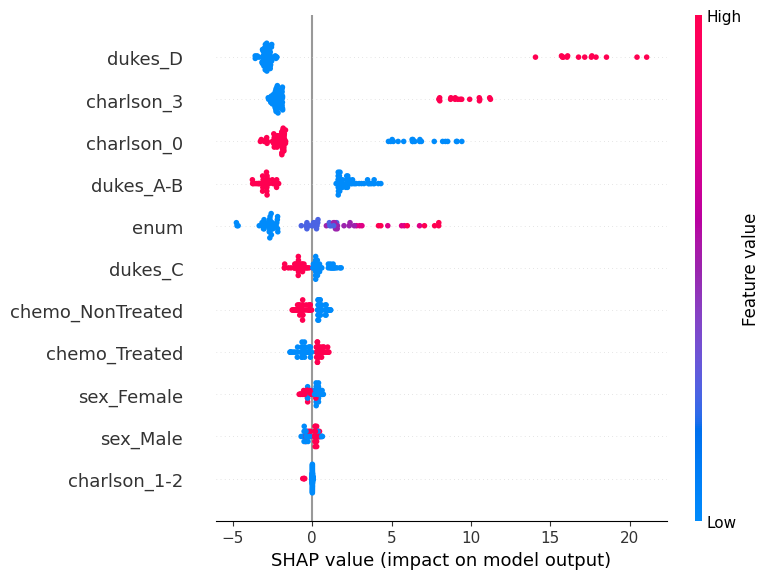

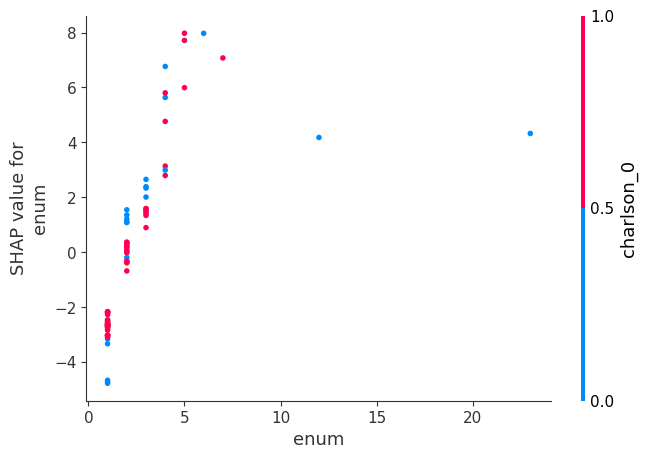

AttributeError: 'RandomSurvivalForest' object has no attribute 'predict_proba'

In [41]:
# model_RSF.get_interpretability_methods(X_train, X_test, y_train, y_test, feature = 'enum', index = 10, plot = True)

### **Permutation Importance**

In [70]:
model_RSF.get_pi_values(X_test, y_test, y_train)

{'sex_Male': 0.020490563803074065,
 'dukes_C': 0.22847818699544747,
 'charlson_1-2': 0.2369293371811328,
 'sex_Female': 0.5776548738028477,
 'chemo_NonTreated': 3.4731061775064713,
 'charlson_0': 3.9672624453312597,
 'chemo_Treated': 4.697831859578565,
 'dukes_A-B': 7.342854801794793,
 'charlson_3': 21.56594900608977,
 'enum': 26.940373221925107,
 'dukes_D': 30.94906952599153}

Displays of variable's importance

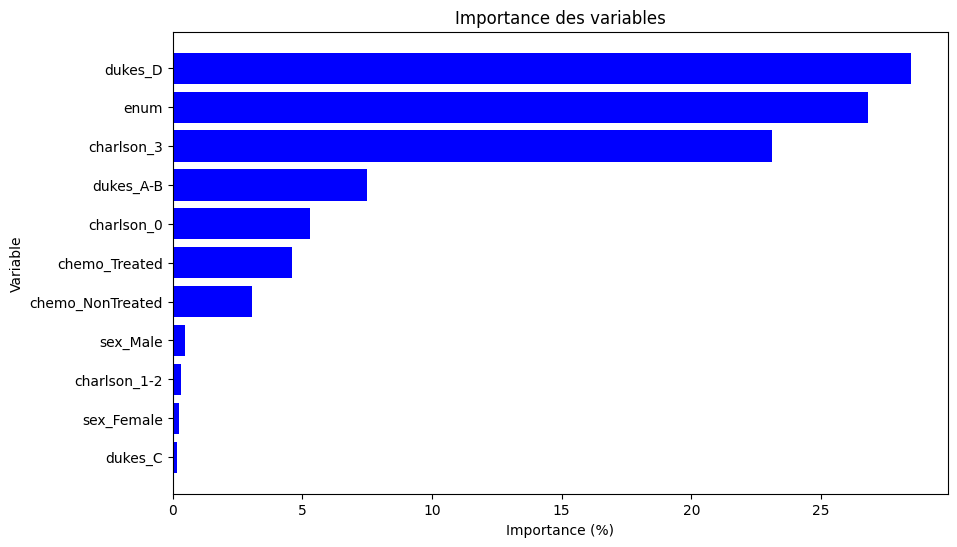

{'dukes_C': 0.16000346586934316,
 'sex_Female': 0.24450101889971115,
 'charlson_1-2': 0.29927600831413137,
 'sex_Male': 0.4624794254861797,
 'chemo_NonTreated': 3.063377951747428,
 'chemo_Treated': 4.593300092541736,
 'charlson_0': 5.294721066215065,
 'dukes_A-B': 7.498257302674329,
 'charlson_3': 23.120580930961275,
 'enum': 26.797616765156373,
 'dukes_D': 28.46588597213443}

In [72]:
model_RSF.get_pi_values(X_test, y_test, y_train, plot = True)

### **SHAP**

For Shap, you can specify whether you want the summary plot with the option (plot=True), but you can also plot the graph representing SHAP values as a function of the values of a specified feature (feature=...).

PermutationExplainer explainer: 82it [02:03,  1.65s/it]                        


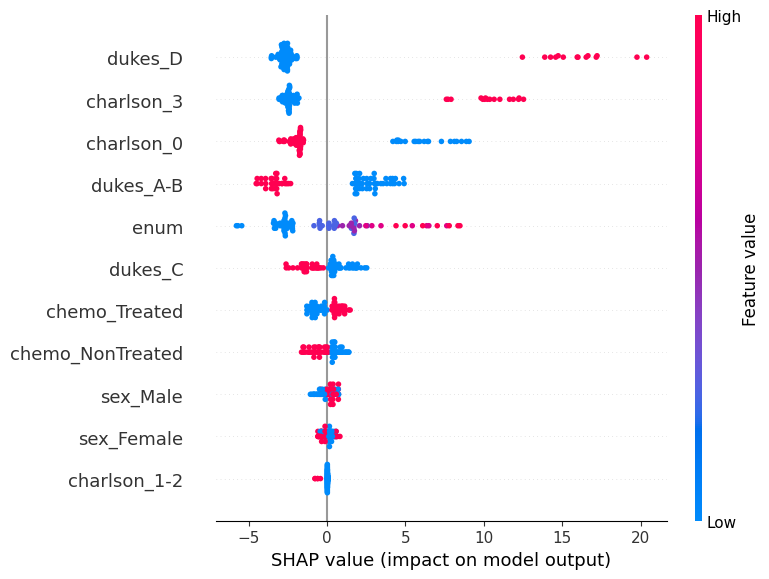

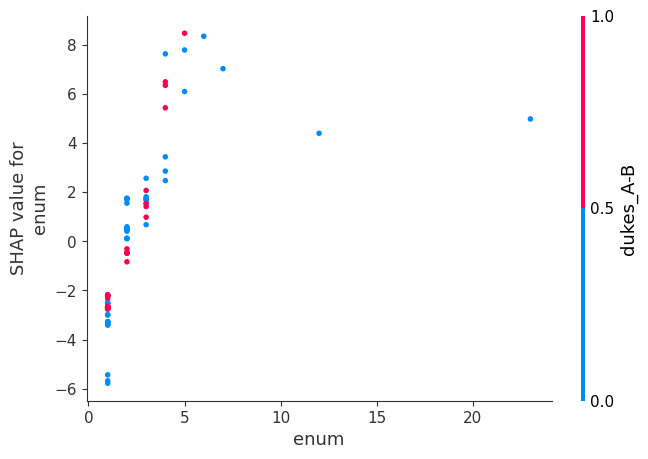

array([[ 1.20905754e+00,  9.94093585e-01, -4.31807470e-01,
        -4.12808848e-01,  4.88420257e+00,  1.83771403e+00,
         1.59980946e+01,  9.05741080e+00,  7.74448121e-02,
         1.22427564e+01,  1.81342744e+00],
       [-4.79719718e-01, -6.40880761e-01,  5.72263655e-01,
         6.89906136e-01,  2.07061467e+00, -9.41537908e-01,
        -2.25410700e+00, -2.31461760e+00,  2.51906024e-02,
        -2.49653532e+00,  1.74587419e+00],
       [-8.08132435e-01, -9.51891650e-01, -3.43923569e-01,
        -4.76386568e-01,  1.82393232e+00, -1.44076342e+00,
        -2.93395148e+00, -1.69422206e+00,  1.37026232e-02,
        -1.88999146e+00, -2.68841989e+00],
       [ 6.86423894e-01,  8.94963118e-01,  8.24008730e-01,
         7.42405112e-01,  4.35766854e+00,  1.46808541e+00,
         1.65221464e+01, -3.06929161e+00,  4.03002679e-02,
        -3.05703529e+00,  5.17915815e-01],
       [ 1.08005399e+00,  7.69913682e-01,  3.44984769e-01,
         3.61626874e-01,  3.43778229e+00, -7.03951710e-01,
  

In [73]:
model_RSF.get_shap_values(X_train, X_test, feature = 'enum',  plot=True,)

### **LIME**

We use here the librairie survlimepy in order to generate LIME interpretation of survival models.